In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Praproses Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

In [ ]:
path = "/content/drive/MyDrive/fake_news_classification_project/Datasets/clean_text_with_stemming.csv"

df = pd.read_csv(path, index_col=0)
df

,title,text,publish_date,category,combined_text
0,ojk suara jam dagang bursa normal pandemi,otoritas jasa uang buka suara pasti jam dagang...,2022-12-30 00:57:21,Nyata,ojk suara jam dagang bursa normal pandemi otor...
1,update pek gempa turki suriah,gempa dahsyat guncang turki suriah senin gempa...,2023-02-11 06:07:13,Nyata,update pek gempa turki suriah gempa dahsyat gu...
2,tim putri indo vs tim putri rusia turnbackhoax id,sumber sebar kali tangkap layar akun akun seba...,2018-01-20 00:00:00,Palsu,tim putri indo vs tim putri rusia turnbackhoax...
3,jokowi heran ri butuh pupuk pabrik setop produksi,presiden joko widodo pt pupuk iskandar muda ac...,2023-02-10 21:58:36,Nyata,jokowi heran ri butuh pupuk pabrik setop produ...
4,camat lampung red zone covid turnbackhoax id,hasil periksa fakta indri pramesti widyaningru...,2020-03-27 00:00:00,Palsu,camat lampung red zone covid turnbackhoax id h...
...,...,...,...,...,...
16755,warga korea selatan vaksin ikut milu turnbackh...,hasil periksa fakta nadine salsabila lansir af...,2022-01-24 00:00:00,Palsu,warga korea selatan vaksin ikut milu turnbackh...
16756,tragedi pesawat jatuh nepal dekade,mei orang tewas celaka pesawat agni air ziarah...,2023-01-16 11:30:57,Nyata,tragedi pesawat jatuh nepal dekade mei orang t...
16757,periksa dito mahendra kpk usut aset eks sekret...,komisi berantas korupsi usut duga alir uang as...,2023-02-06 16:10:38,Nyata,periksa dito mahendra kpk usut aset eks sekret...
16758,meni istri cerai suami gara gara dukung jokowi...,judul sunting edit judul asli menit meni istri...,2020-07-22 00:00:00,Palsu,meni istri cerai suami gara gara dukung jokowi...


In [ ]:
# Split the dataset into real and fake news dataframes
real_news_df = df[df['category'] == 'Nyata']
fake_news_df = df[df['category'] == 'Palsu']

# Sort the dataframe by the date column in ascending order
sorted_real_news = real_news_df.sort_values(by='publish_date', ascending=False).reset_index(drop=True)
sorted_fake_news = fake_news_df.sort_values(by='publish_date', ascending=False).reset_index(drop=True)

In [ ]:
real_news_sample_size = int(len(sorted_real_news) * 0.08)
fake_news_sample_size = int(len(sorted_fake_news) * 0.08)

In [ ]:
# Sample 10% of the rows from each dataframe randomly
real_news_sample = sorted_real_news.sample(n=real_news_sample_size)
fake_news_sample = sorted_fake_news.sample(n=fake_news_sample_size)

In [ ]:
# Sample 10% of the rows from each dataframe sequentially
real_news_sample = sorted_real_news[:real_news_sample_size] # between 2023-02-14 and 2023-02-10
fake_news_sample = sorted_fake_news[:fake_news_sample_size] # between 2023-01-18 and 2022-04-27

In [ ]:
# Combine the samples into a single dataframe
sampled_df = pd.concat([real_news_sample, fake_news_sample]).sample(frac=1).reset_index(drop=True)

total_df = pd.concat([sorted_real_news, sorted_fake_news]).sample(frac=1).reset_index(drop=True)

Palsu    697
Nyata    643
Name: category, dtype: int64


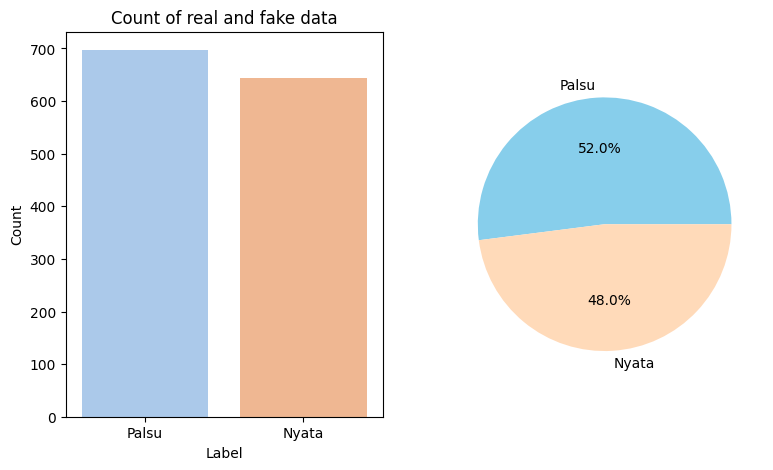

In [ ]:
print(sampled_df["category"].value_counts())
fig, ax = plt.subplots(1,2, figsize=(9, 5))
g1 = sns.countplot(data=sampled_df, x='category', ax=ax[0] ,palette="pastel")
g1.set_title("Count of real and fake data")
g1.set_ylabel("Count")
g1.set_xlabel("Label")
g2 = plt.pie(sampled_df["category"].value_counts().values,explode=[0,0],labels=sampled_df.category.value_counts().index, autopct='%1.1f%%',colors=['SkyBlue','PeachPuff'])
fig.show()

In [ ]:
!pip install mlxtend

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
# create binary labels
sampled_df['labels'] = sampled_df['category'].map({'Nyata': 0, 'Palsu': 1})

# split up the data_train into training and temporary sets
train_sentences, temporary_sentences, train_labels, temporary_labels = train_test_split(sampled_df["combined_text"].to_numpy(),
                                                                                        sampled_df["labels"].to_numpy(),
                                                                                        test_size=0.4,
                                                                                        random_state=42)

# split up the data_train into validation and test sets
val_sentences, test_sentences, val_labels, test_labels = train_test_split(temporary_sentences,
                                                                          temporary_labels,
                                                                          test_size=0.5,
                                                                          random_state=42)

In [ ]:
len(train_sentences), len(val_sentences), len(test_sentences), len(train_labels), len(val_labels), len(test_labels)

In [ ]:
# convert sentences to sequences
vocab_size = 20000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_sentences)
train_tokens = tokenizer.texts_to_sequences(train_sentences)
val_tokens = tokenizer.texts_to_sequences(val_sentences)
test_tokens = tokenizer.texts_to_sequences(test_sentences)

In [ ]:
word2idx = tokenizer.word_index
vocab_size = len(word2idx)
print("Found %s unique tokens." % vocab_size)

In [ ]:
max_length = 100

# pad sequences to get N x T matrix
train_ds = pad_sequences(train_tokens, maxlen=max_length, padding='post', truncating='post')
print('Shape of data train tensor: ', train_ds.shape)
print(train_ds)

val_ds = pad_sequences(val_tokens, maxlen=max_length, padding='post', truncating='post')
print('Shape of data validation tensor: ', val_ds.shape)
print(val_ds)

test_ds = pad_sequences(test_tokens, maxlen=max_length, padding='post', truncating='post')
print('Shape of data test tensor: ', test_ds.shape)
print(test_ds)

In [ ]:
# define the hyperparameters to be tested

num_units = [2, 4, 8]

## LSTM Model

from: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM

The requirements to use the cuDNN implementation are:

*   activation == tanh
*   recurrent_activation == sigmoid
*   recurrent_dropout == 0
*   unroll is False
*   use_bias is True
*   Inputs, if use masking, are strictly right-padded.
*   Eager execution is enabled in the outermost context.

In [ ]:
model = tf.keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=768,
                           input_length=100
                           ),
    keras.layers.LSTM(units=8),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryCrossentropy(),'accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 768)          9585408   
                                                                 
 lstm_3 (LSTM)               (None, 8)                 24864     
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,610,281
Trainable params: 9,610,281
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_ds,
    train_labels,
    epochs=10,
    batch_size=64,
    validation_data=[val_ds, val_labels],
    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    verbose=0,
)

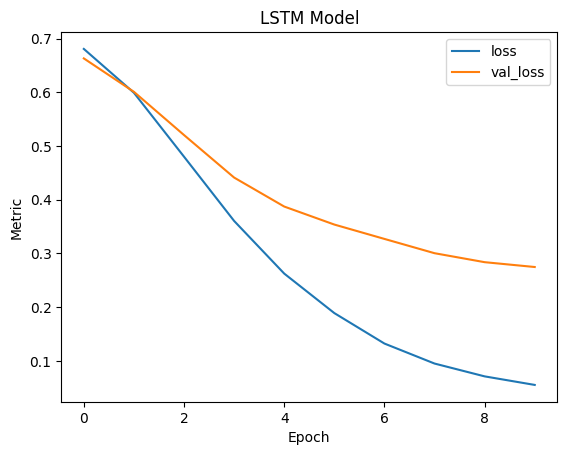

In [ ]:
# plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

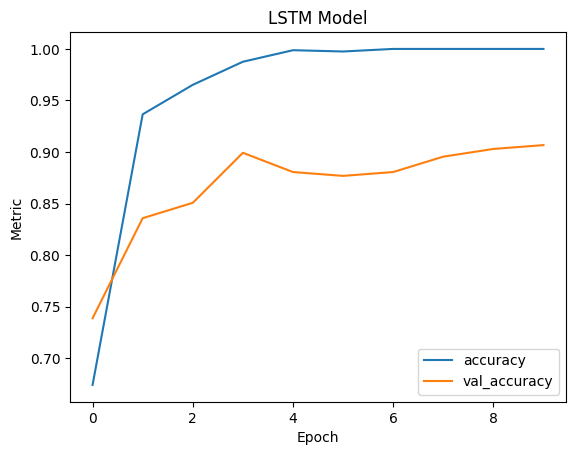

In [ ]:
# plot accuracy per iteration
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

In [ ]:
lstm_test_pred = (model.predict(test_ds) > 0.5).astype("int32")

9/9 [==============================] - 1s 18ms/step


In [ ]:
print("Model LSTM")
print(f"Accuracy score    : {accuracy_score(test_labels, lstm_test_pred)}")
print(f"Precision score   : {precision_score(test_labels, lstm_test_pred)}")
print(f"Recall score      : {recall_score(test_labels, lstm_test_pred)}")
print(f"F1 score          : {f1_score(test_labels, lstm_test_pred)}")

Model LSTM
Accuracy score    : 0.8955223880597015
Precision score   : 0.8904109589041096
Recall score      : 0.9154929577464789
F1 score          : 0.9027777777777778


In [ ]:
print(classification_report(test_labels, lstm_test_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       126
           1       0.89      0.92      0.90       142

    accuracy                           0.90       268
   macro avg       0.90      0.89      0.89       268
weighted avg       0.90      0.90      0.90       268



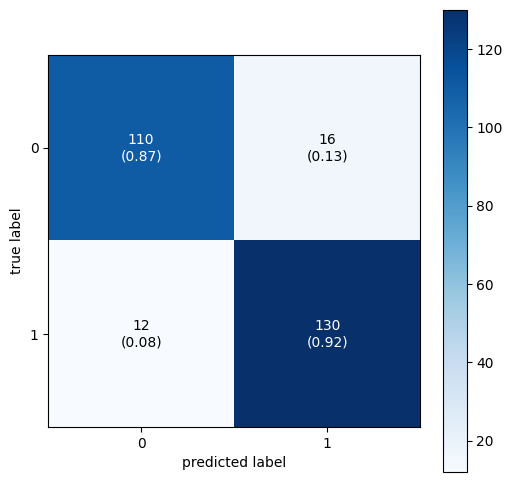

In [ ]:
conf_mat = confusion_matrix(test_labels, lstm_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                figsize=(6,6),
                                colorbar=True,
                                # show_absolute=False,
                                show_normed=True,)

plt.show()

In [ ]:
# Determine the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, lstm_test_pred)

# Calculate the Youden's J statistic for each threshold
j_scores = tpr - fpr

# Find the optimal threshold that maximizes the Youden's J statistic
optimal_threshold = thresholds[np.argmax(j_scores)]

# Use the optimal threshold to make binary predictions
test_preds_optimal = (lstm_test_pred >= optimal_threshold).astype(int)

# Calculate the area under the ROC curve (AUC-ROC)
roc_auc = auc(fpr, tpr)

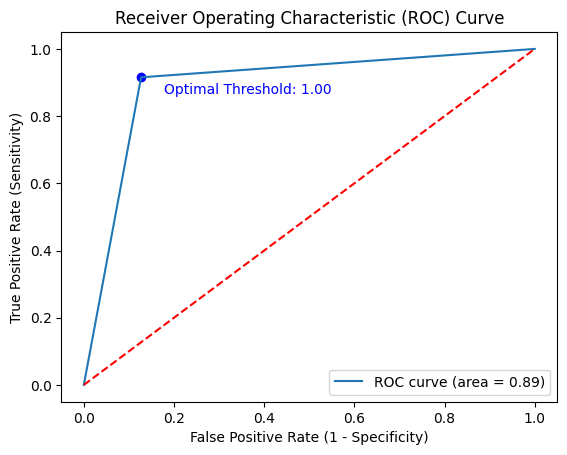

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.scatter(fpr[np.argmax(j_scores)], tpr[np.argmax(j_scores)], color='b')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.2f}',
             (fpr[np.argmax(j_scores)] + 0.05, tpr[np.argmax(j_scores)] - 0.05),
             color='b')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
rand = random.randint(0, len(sorted_fake_news)-1)
text = total_df["combined_text"].iloc[rand]
_label = total_df["category"].iloc[rand]

In [ ]:
sequence_list = tokenizer.texts_to_sequences(text)
reshaped_list = [element for sublist in sequence_list for element in sublist]

padded_sequences = [reshaped_list]
padded_sequences = pad_sequences(padded_sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
text

'foto serang udara luncur nato afrika libya turnbackhoax id hasil periksa fakta renanda dwina putri foto sungguh hasil computer generated imagery al clark artikel the aviationist judul artwork israeli f strike on tehran on day of the war on iran s nuclear program terbit maret lengkap jelas kategori konteks salah sumber twitter narasi the most air strikes ever launched in africa by nato was more than on libya in with over civilian casualities when nato was questioned about civilian casualities and the death of gaddafi children they insisted that it was collateral damage and normal in wars serang udara luncur afrika nato libya korban sipil nato korban sipil mati anak anak gaddafi sikeras rusa tambah normal perang jelas akun twitter african hub unggah cuit foto klaim serang udara luncur nato afrika libya cuit unggah maret atensi ribu suka ribu retweet dasar hasil telusur foto hasil computer generated imagery al clark the aviationist the aviationist blog terbang jalan david cenciotti jurna

In [ ]:
prediction = model.predict(padded_sequences)

# Convert prediction to human-readable class label
predicted_class = "Palsu" if prediction[0] >= roc_auc else "Nyata"
print("Artikel ini adalah {} diprediksi sebagai: {}".format(_label, predicted_class))

1/1 [==============================] - 0s 40ms/step
[0.6782086]
Artikel ini adalah Palsu diprediksi sebagai: Nyata


## Conv1D Model

In [ ]:
model = tf.keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size,
                           output_dim=768,
                           input_length=100
                           ),
    keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu'),
    keras.layers.GlobalMaxPooling1D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryCrossentropy(),'accuracy']
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 768)          9585408   
                                                                 
 conv1d_2 (Conv1D)           (None, 100, 8)            6152      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,591,569
Trainable params: 9,591,569
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(
    train_ds,
    train_labels,
    epochs=10,
    batch_size=64,
    validation_data=[val_ds, val_labels],
    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    verbose=0,
)

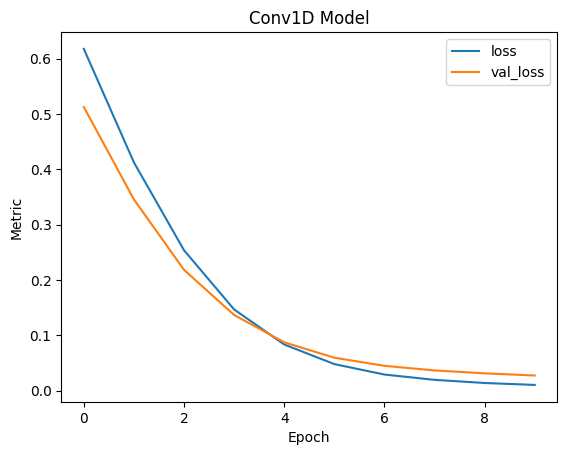

In [ ]:
# plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Conv1D Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

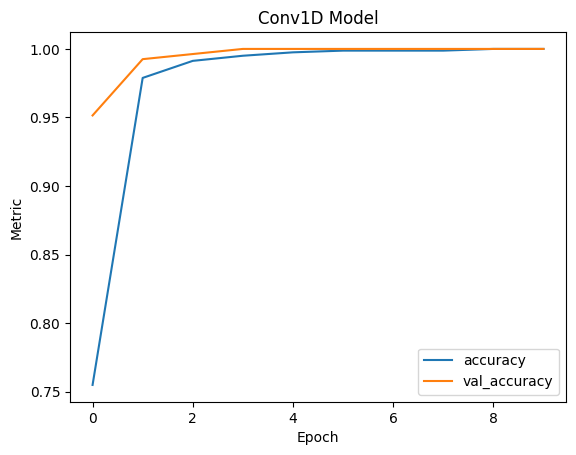

In [ ]:
# plot accuracy per iteration
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("Conv1D Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

In [ ]:
conv_test_pred = (model.predict(test_ds) > 0.5).astype("int32")

9/9 [==============================] - 0s 6ms/step


In [ ]:
print("Model Conv1D")
print(f"Accuracy score    : {accuracy_score(test_labels, conv_test_pred)}")
print(f"Precision score   : {precision_score(test_labels, conv_test_pred)}")
print(f"Recall score      : {recall_score(test_labels, conv_test_pred)}")
print(f"F1 score          : {f1_score(test_labels, conv_test_pred)}")

Model Conv1D
Accuracy score    : 0.9925373134328358
Precision score   : 0.9929577464788732
Recall score      : 0.9929577464788732
F1 score          : 0.9929577464788732


In [ ]:
print(classification_report(test_labels, conv_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       126
           1       0.99      0.99      0.99       142

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



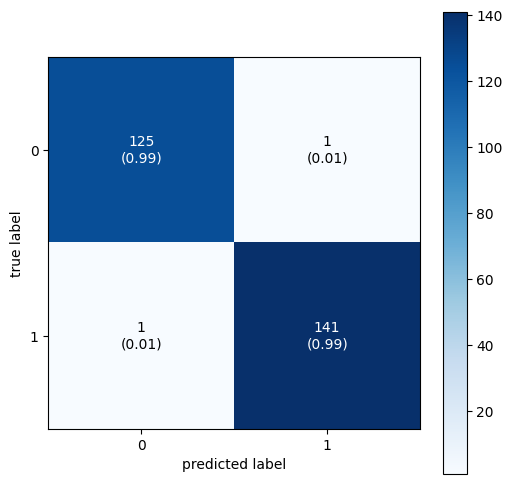

In [ ]:
conf_mat = confusion_matrix(test_labels, conv_test_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                figsize=(6,6),
                                colorbar=True,
                                # show_absolute=False,
                                show_normed=True,)

plt.show()

In [ ]:
# Determine the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, conv_test_pred)

# Calculate the Youden's J statistic for each threshold
j_scores = tpr - fpr

# Find the optimal threshold that maximizes the Youden's J statistic
optimal_threshold = thresholds[np.argmax(j_scores)]

# Use the optimal threshold to make binary predictions
test_preds_optimal = (conv_test_pred >= optimal_threshold).astype(int)

# Calculate the area under the ROC curve (AUC-ROC)
roc_auc = auc(fpr, tpr)

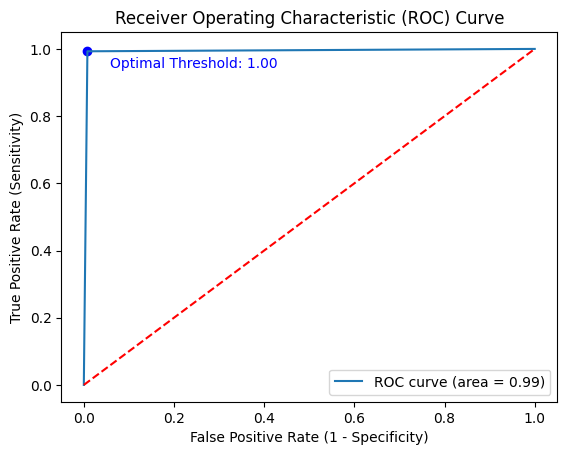

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.scatter(fpr[np.argmax(j_scores)], tpr[np.argmax(j_scores)], color='b')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.2f}',
             (fpr[np.argmax(j_scores)] + 0.05, tpr[np.argmax(j_scores)] - 0.05),
             color='b')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
rand = random.randint(0, len(sorted_fake_news)-1)
text = total_df["combined_text"].iloc[rand]
_label = total_df["category"].iloc[rand]

In [ ]:
sequence_list = tokenizer.texts_to_sequences(text)
reshaped_list = [element for sublist in sequence_list for element in sublist]

padded_sequences = [reshaped_list]
padded_sequences = pad_sequences(padded_sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
text

'kenal sosok rekam detik detik yeti airlines nepal media sosial geger video detik detik pesawat yeti airlines celaka nepal tumpang rekam peristiwa lansir bbc selasa video dadak viral india video salah tumpang sonu jaiswal siar langsung detik detik yeti airlines celaka tayang video kawasan bandara pokhara pesawat darat pesawat sadar temu ajal rekam video pesawat lesat bangun hias ladang warna cokelat hijau pria abadi video putar arah kamera senyum sosok rekam sonu jaiswal tumpang ghazipur india unjung nepal tumpang pesawat kathmandu pokhara duduk desa empat pria insan jiwa hati sayang pukul tragedi timpa hidup keluarga empat pria protes tuntut kompensasi keluarga korban empat pria usia an an teman tahun habis duduk empat pria pergi nepal januari unjung kuil pashupatinath kuil pinggir kathmandu dedikasi dewa hindu shiwa jalan kabar ide jaiswal ayah anak doa kuil putra unjung kuil empat pria berangkat minggu pokhara kota wisata letak gunung annapurna paralayang rencana kathmandu takdir un

In [ ]:
prediction = model.predict(padded_sequences)

# Convert prediction to human-readable class label
predicted_class = "Palsu" if prediction[0] >= roc_auc else "Nyata"
print("Artikel ini adalah {} diprediksi sebagai: {}".format(_label, predicted_class))

1/1 [==============================] - 0s 25ms/step
Artikel ini adalah Nyata diprediksi sebagai: Nyata


## Prepare Input for BERT Model

In [ ]:
!pip install transformers[tf-cuda]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.3 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, TFBertModel

bert_tokenizer = BertTokenizer.from_pretrained('indolem/indobert-base-uncased')
bert_model = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [ ]:
for layer in bert_model.layers:
    layer.trainable=False

In [ ]:
# tokenize and encode sequences
max_length = 100
encoded_train_data = bert_tokenizer.batch_encode_plus(
    train_sentences.tolist(), # Text to encode.
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=max_length,    # Pad & truncate all sentences.
    pad_to_max_length=True,
    return_attention_mask=True, # Construct attn. masks.
    return_tensors='pt'         # Return pytorch tensors.
)

encoded_val_data = bert_tokenizer.batch_encode_plus(
    val_sentences.tolist(),   # Text to encode.
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=max_length,    # Pad & truncate all sentences.
    pad_to_max_length=True,
    return_attention_mask=True, # Construct attn. masks.
    return_tensors='pt'         # Return pytorch tensors.
)

encoded_test_data = bert_tokenizer.batch_encode_plus(
    test_sentences.tolist(),  # Text to encode.
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=max_length,    # Pad & truncate all sentences.
    pad_to_max_length=True,
    return_attention_mask=True, # Construct attn. masks.
    return_tensors='pt'         # Return pytorch tensors.
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Get input IDs and attention masks
train_ids = np.array(encoded_train_data['input_ids'], dtype=np.int32)
train_mask = np.array(encoded_train_data['attention_mask'], dtype=np.int32)
train_labels = np.array(train_labels.tolist())

# Get input IDs and attention masks
val_ids = np.array(encoded_val_data['input_ids'], dtype=np.int32)
val_mask = np.array(encoded_val_data['attention_mask'], dtype=np.int32)
val_labels = np.array(val_labels.tolist())

# Get input IDs and attention masks
test_ids = np.array(encoded_test_data['input_ids'], dtype=np.int32)
test_mask = np.array(encoded_test_data['attention_mask'], dtype=np.int32)
test_labels = np.array(test_labels.tolist())

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_ids, train_mask, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(32)

In [ ]:
train_data  = train_dataset.map(lambda train_ids, train_mask, train_labels: (train_ids, train_mask))

In [ ]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110558208 
                                                                 
Total params: 110,558,208
Trainable params: 0
Non-trainable params: 110,558,208
_________________________________________________________________


In [ ]:
text = "Ini adalah contoh teks."
encoded_input = bert_tokenizer(text, return_tensors='tf')
output = bert_model(encoded_input)

In [ ]:
output

## IndoBERT+LSTM

In [ ]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(100,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(100,), dtype=tf.int32, name='attention_mask')

# Get BERT outputs
bert_output = bert_model([input_ids, attention_mask])

# Extract pooler_output
pooler_output = bert_output.pooler_output
# cls_hs = bert_output.last_hidden_state

# Add Reshape layer to convert 2D tensor to 3D tensor
reshaped_output = tf.keras.layers.Reshape((1, -1))(pooler_output)

# Add dense layer after BERT layer
lstm_layer = tf.keras.layers.LSTM(units=8)(reshaped_output)

# Add output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_layer)

# Define model
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryCrossentropy(),'accuracy']
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  110558208   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [ ]:
history = model.fit(
    [train_ids, train_mask],
    train_labels,
    epochs=10,
    batch_size=64,
    validation_data=([val_ids, val_mask], val_labels),
    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    # verbose=0,
)

Epoch 1/10
13/13 [==============================] - 47s 966ms/step - loss: 0.6587 - binary_crossentropy: 0.6587 - accuracy: 0.6343 - val_loss: 0.5681 - val_binary_crossentropy: 0.5681 - val_accuracy: 0.8694
Epoch 2/10
13/13 [==============================] - 8s 628ms/step - loss: 0.5204 - binary_crossentropy: 0.5204 - accuracy: 0.8744 - val_loss: 0.4030 - val_binary_crossentropy: 0.4030 - val_accuracy: 0.8769
Epoch 3/10
13/13 [==============================] - 8s 633ms/step - loss: 0.3993 - binary_crossentropy: 0.3993 - accuracy: 0.8769 - val_loss: 0.2870 - val_binary_crossentropy: 0.2870 - val_accuracy: 0.9291
Epoch 4/10
13/13 [==============================] - 7s 576ms/step - loss: 0.3097 - binary_crossentropy: 0.3097 - accuracy: 0.9117 - val_loss: 0.2325 - val_binary_crossentropy: 0.2325 - val_accuracy: 0.9328
Epoch 5/10
13/13 [==============================] - 8s 640ms/step - loss: 0.2791 - binary_crossentropy: 0.2791 - accuracy: 0.9142 - val_loss: 0.2097 - val_binary_crossentropy:

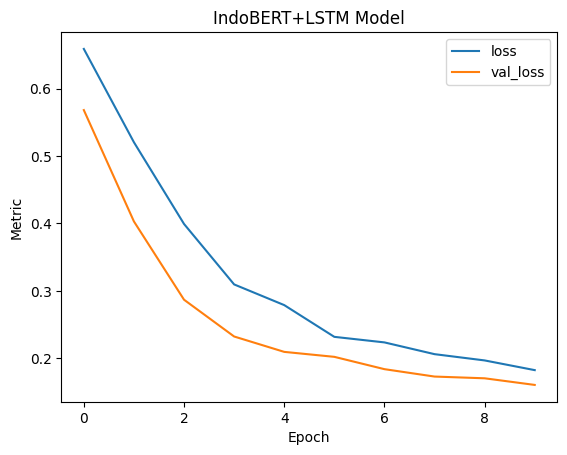

In [ ]:
# plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("IndoBERT+LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

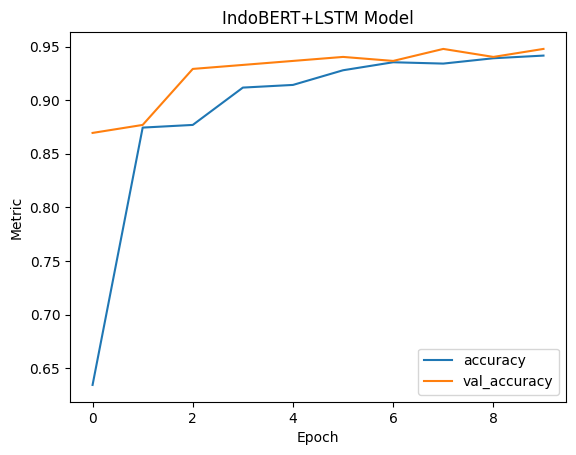

In [ ]:
# plot accuracy per iteration
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("IndoBERT+LSTM Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

In [ ]:
test_pred = (model.predict([test_ids, test_mask]) > 0.5).astype("int32")

9/9 [==============================] - 5s 205ms/step


In [ ]:
print("Model IndoBERT+LSTM")
print(f"Accuracy score    : {accuracy_score(test_labels, test_pred)}")
print(f"Precision score   : {precision_score(test_labels, test_pred)}")
print(f"Recall score      : {recall_score(test_labels, test_pred)}")
print(f"F1 score          : {f1_score(test_labels, test_pred)}")

Model IndoBERT+LSTM
Accuracy score    : 0.9888059701492538
Precision score   : 0.9790209790209791
Recall score      : 1.0
F1 score          : 0.989399293286219


In [ ]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       128
           1       0.98      1.00      0.99       140

    accuracy                           0.99       268
   macro avg       0.99      0.99      0.99       268
weighted avg       0.99      0.99      0.99       268



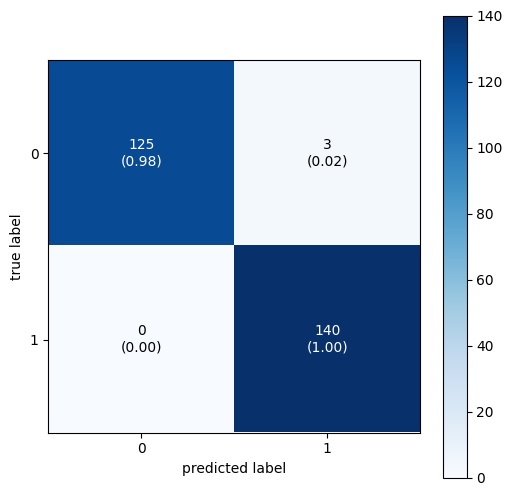

In [ ]:
conf_mat = confusion_matrix(test_labels, test_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                figsize=(6,6),
                                colorbar=True,
                                # show_absolute=False,
                                show_normed=True,)

plt.show()

In [ ]:
# Determine the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculate the Youden's J statistic for each threshold
j_scores = tpr - fpr

# Find the optimal threshold that maximizes the Youden's J statistic
optimal_threshold = thresholds[np.argmax(j_scores)]

# Use the optimal threshold to make binary predictions
test_preds_optimal = (test_pred >= optimal_threshold).astype(int)

# Calculate the area under the ROC curve (AUC-ROC)
roc_auc = auc(fpr, tpr)

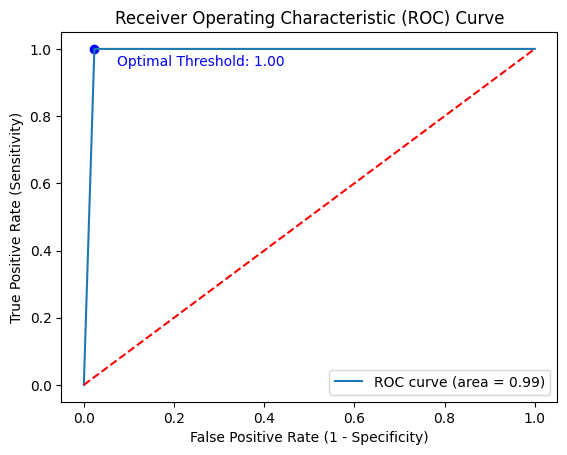

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.scatter(fpr[np.argmax(j_scores)], tpr[np.argmax(j_scores)], color='b')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.2f}',
             (fpr[np.argmax(j_scores)] + 0.05, tpr[np.argmax(j_scores)] - 0.05),
             color='b')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Pengujian Model

In [ ]:
rand = random.randint(0, len(total_df)-1)
text = total_df["combined_text"].iloc[rand]
_label = total_df["category"].iloc[rand]

In [ ]:
encoded_data = bert_tokenizer.encode_plus(
    text,
    max_length=100,           # Maximum length of the input sequence
    padding='max_length',     # Pad or truncate the sequence to the max_length value
    truncation=True,          # Truncate the sequence if it exceeds max_length
    add_special_tokens=True,  # Add special tokens ([CLS], [SEP])
    return_tensors='pt'       # Return PyTorch tensors
)

In [ ]:
input_ids = np.array(encoded_data['input_ids'], dtype=np.int32)
attention_mask = np.array(encoded_data['attention_mask'], dtype=np.int32)

In [ ]:
input_ids

array([[    3, 11736, 16696,  7563,  5719,   954,   944,  5427,  6938,
         5719,   954,   944,  5427, 30705,  3592,  2939,  1476,  5427,
         1999,  5694, 30601,  2706,  7397,  8092,  2043,  1481, 11736,
        16696, 11736, 16696,  7563,  5719,   954,   944,  5427,  3069,
         6938,  5719,   954,   944,  5427,  5123,  3592,  4067,  4487,
         4319,  2776, 17493,  4652, 29085,  1999,  5719,   954,   944,
         5427,  3910,  2939,  1476, 11736, 16696,  6662,  4067,  5427,
         7397,  5957,  2706, 18836,  7141, 18970,  3592,  2043,  1481,
         2939,  1476,  5427,  7397,  4652, 16492, 12415,  8887,  4067,
         4067,  7107, 10988,  2706,  4652,  1983, 11736, 16696,  7563,
         5719,   954,   944,  5427,  7563,  5719,   954,   944,  5427,
            4]], dtype=int32)

In [ ]:
text

'konsultasi psikolog pakai bpjs sehat gratis bpjs sehat jamin biaya layan sehat serta alami kait kondisi mental butuh awat konsultasi psikolog konsultasi psikolog pakai bpjs sehat mudah gratis bpjs sehat tanggung biaya obat tahap lanjut dasar diagnosis pasien catat serta bpjs sehat aktif layan konsultasi psikolog manfaat obat sehat mental murah kondisi derita bilang kronis biaya awat layan sehat mental pasien cakup rehabilitasi terapi obat obat prosedur jenjang kondisi pasien baik konsultasi psikolog pakai bpjs sehat pakai bpjs sehat konsultasi psikolog faskes tingkat konsultasi psikolog pakai bpjs sehat faskes tingkat sesuai lokasi daftar serta faskes tingkat puskesmas tara praktik dokter klinik pratama tara rumah sakit kelas d tara konsultasi faskes tingkat faskes administrasi kait pol jiwa perlu konsultasi dokter psikolog lupa berkas dukung kartu bpjs sehat fotokopi ktp fotokopi kk tahap administrasi selesai pasien konsultasi tahap pasien tinjau gejala sakit rasa kondisi layan spesi

In [ ]:
print("Model IndoBERT+LSTM")
prediction = model.predict([input_ids, attention_mask])

# Convert prediction to human-readable class label
predicted_class = "Nyata" if (_label == "Nyata" and prediction[0] <= roc_auc - 0.05) else "Palsu" if (_label == "Palsu" and prediction[0] > roc_auc - 0.05) else "Nyata"
print("Artikel ini adalah {} diprediksi sebagai: {}".format(_label, predicted_class))

Model IndoBERT+LSTM
1/1 [==============================] - 0s 85ms/step
Artikel ini adalah Nyata diprediksi sebagai: Nyata


## IndoBERT+Conv1D

In [ ]:
# Define input layers
input_ids = tf.keras.layers.Input(shape=(100,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(100,), dtype=tf.int32, name='attention_mask')

# Get BERT outputs
bert_output = bert_model([input_ids, attention_mask])

# Extract pooler_output
pooler_output = bert_output.pooler_output
# cls_hs = bert_output.last_hidden_state

# Add Reshape layer to convert 2D tensor to 3D tensor
reshaped_output = tf.keras.layers.Reshape((1, -1))(pooler_output)
# reshaped_output = tf.keras.layers.Reshape((768, -1))(tf.expand_dims(pooler_output, axis=-1))
# reshaped_output = tf.keras.layers.Reshape((100, 768, 1))(tf.expand_dims(pooler_output, axis=-1))

# Add Conv1D layer after BERT layer
conv_layer = tf.keras.layers.Conv1D(filters=8, kernel_size=1, activation='relu')(reshaped_output)
pooling_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)

# Add output layer
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(pooling_layer)

# Define model
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryCrossentropy(),'accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  110558208   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [ ]:
history = model.fit(
    [train_ids, train_mask],
    train_labels,
    epochs=10,
    batch_size=64,
    validation_data=([val_ids, val_mask], val_labels),
    callbacks=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5),
    # verbose=0,
)

Epoch 1/10
13/13 [==============================] - 32s 1s/step - loss: 0.6085 - binary_crossentropy: 0.6085 - accuracy: 0.7065 - val_loss: 0.4551 - val_binary_crossentropy: 0.4551 - val_accuracy: 0.8769
Epoch 2/10
13/13 [==============================] - 8s 660ms/step - loss: 0.4505 - binary_crossentropy: 0.4505 - accuracy: 0.8470 - val_loss: 0.3186 - val_binary_crossentropy: 0.3186 - val_accuracy: 0.9328
Epoch 3/10
13/13 [==============================] - 8s 595ms/step - loss: 0.3487 - binary_crossentropy: 0.3487 - accuracy: 0.8955 - val_loss: 0.2522 - val_binary_crossentropy: 0.2522 - val_accuracy: 0.9403
Epoch 4/10
13/13 [==============================] - 8s 593ms/step - loss: 0.3078 - binary_crossentropy: 0.3078 - accuracy: 0.8955 - val_loss: 0.2137 - val_binary_crossentropy: 0.2137 - val_accuracy: 0.9366
Epoch 5/10
13/13 [==============================] - 8s 647ms/step - loss: 0.2504 - binary_crossentropy: 0.2504 - accuracy: 0.9254 - val_loss: 0.1893 - val_binary_crossentropy: 0.

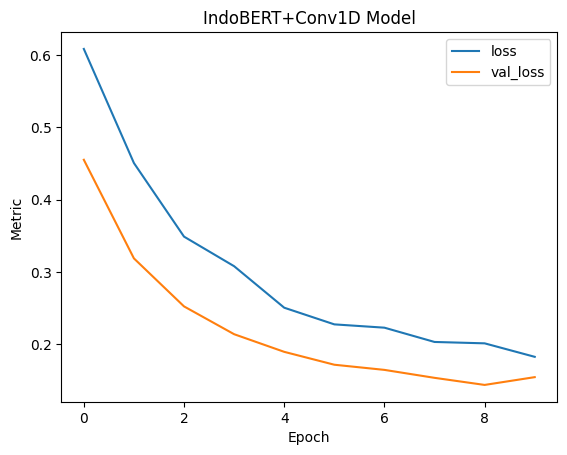

In [ ]:
# plot loss per iteration
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("IndoBERT+Conv1D Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

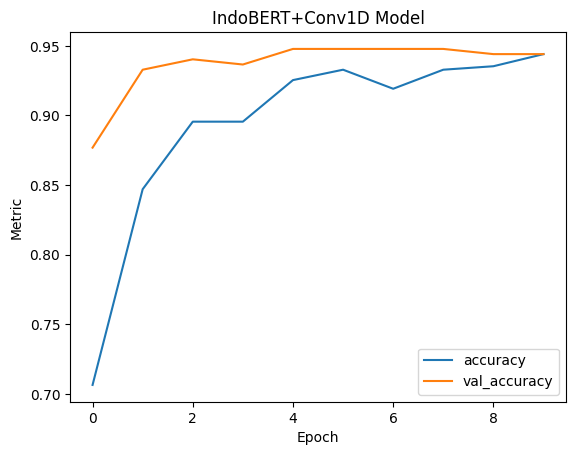

In [ ]:
# plot accuracy per iteration
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title("IndoBERT+Conv1D Model")
plt.xlabel("Epoch")
plt.ylabel("Metric")
plt.legend()

In [ ]:
test_pred = (model.predict([test_ids, test_mask]) > 0.5).astype("int32")

9/9 [==============================] - 5s 205ms/step


In [ ]:
print("Model IndoBERT+Conv1D")
print(f"Accuracy score    : {accuracy_score(test_labels, test_pred)}")
print(f"Precision score   : {precision_score(test_labels, test_pred)}")
print(f"Recall score      : {recall_score(test_labels, test_pred)}")
print(f"F1 score          : {f1_score(test_labels, test_pred)}")

Model IndoBERT+Conv1D
Accuracy score    : 0.9738805970149254
Precision score   : 0.9523809523809523
Recall score      : 1.0
F1 score          : 0.975609756097561


In [ ]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       128
           1       0.95      1.00      0.98       140

    accuracy                           0.97       268
   macro avg       0.98      0.97      0.97       268
weighted avg       0.98      0.97      0.97       268



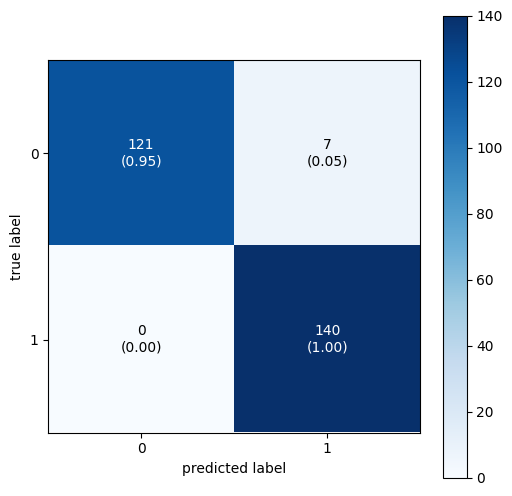

In [ ]:
conf_mat = confusion_matrix(test_labels, test_pred)
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                figsize=(6,6),
                                colorbar=True,
                                # show_absolute=False,
                                show_normed=True,)

plt.show()

In [ ]:
# Determine the false positive rate, true positive rate, and threshold values for the ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)

# Calculate the Youden's J statistic for each threshold
j_scores = tpr - fpr

# Find the optimal threshold that maximizes the Youden's J statistic
optimal_threshold = thresholds[np.argmax(j_scores)]

# Use the optimal threshold to make binary predictions
test_preds_optimal = (test_pred >= optimal_threshold).astype(int)

# Calculate the area under the ROC curve (AUC-ROC)
roc_auc = auc(fpr, tpr)

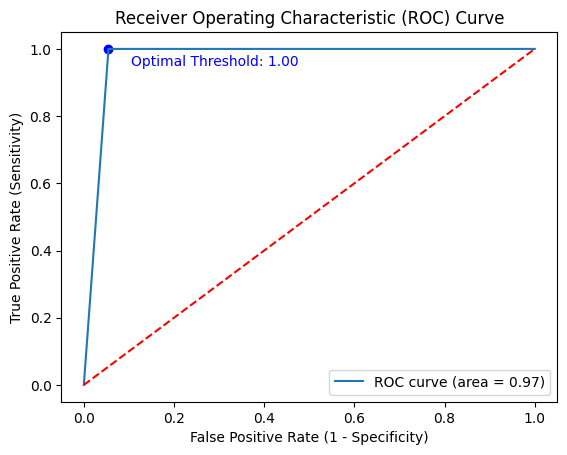

In [ ]:
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.scatter(fpr[np.argmax(j_scores)], tpr[np.argmax(j_scores)], color='b')
plt.annotate(f'Optimal Threshold: {optimal_threshold:.2f}',
             (fpr[np.argmax(j_scores)] + 0.05, tpr[np.argmax(j_scores)] - 0.05),
             color='b')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Pengujian Model

In [ ]:
rand = random.randint(0, len(total_df)-1)
text = total_df["combined_text"].iloc[rand]
_label = total_df["category"].iloc[rand]

In [ ]:
encoded_data = bert_tokenizer.encode_plus(
    text,
    max_length=100,           # Maximum length of the input sequence
    padding='max_length',     # Pad or truncate the sequence to the max_length value
    truncation=True,          # Truncate the sequence if it exceeds max_length
    add_special_tokens=True,  # Add special tokens ([CLS], [SEP])
    return_tensors='pt'       # Return PyTorch tensors
)

In [ ]:
input_ids = np.array(encoded_data['input_ids'], dtype=np.int32)
attention_mask = np.array(encoded_data['attention_mask'], dtype=np.int32)

In [ ]:
input_ids

array([[    3, 23992,   940,  4177,  1556, 24365,  1827,  1827,  1912,
         4837, 14593, 22451, 14810,  5876,   962,  2593,  3888,  4177,
         1556, 23992,   940, 24365, 15620,  3461,  8820,  5548,  1892,
         2057, 10946,  2851,  8096, 11182, 10522,  3888, 16312,   936,
        11258,  1738,  4079, 26460,  6613,  1827,  1827, 11997,  1912,
         9003,  4837, 14593,  1827,  2647, 10215, 15620,  5729,  5740,
         8009,  1827, 15620,  1646,  3289,  2270,  3030,  8096, 24365,
        23992,   940,  2647,  4177,  1556, 16849,  6613,  1646,  3289,
         5999,  1519, 15124, 17543,  4837, 14593, 14888,  1534,   945,
         1561,  1479,  5687,  4219,  3559, 28912,  1528,  5687,  4219,
         1503,  4337,  1892,  1718,  9421, 11477, 15233,  1476,  7336,
            4]], dtype=int32)

In [ ]:
text

'kjp cabut kurung anak anak rumah psbb turnbackhoax id pesan cabut kjp kurung lurah dinas didik dki jakarta keluar bijak informasi sanksi konten sesat pesan beranta whatsapp assalamualaikum ingat anak anak agr rumah laku psbb anak nya bawa lurah minta terang ambil anak lurah orang tua sekolah guru sanksi kurung kjp nya cabut yuk ingat orang tua kerjasamanya ayo dukung psbb cegah sebar virus corona covid virus coron hilang jakarta indonesia biar nikmat susanan puasa suasana lebaran anak anak aktivitas sekolah main latih sepakbola terima kasih mengigatkan edar info pesan beranta whatsapp anak liar rumah psbb bawa lurah sanksi kurung fasilitas kjp cabut telusur perintah provinsi dki jakarta terbit atur gubernur nomor laksana batas sosial skala tangan corona virus disease provinsi daerah khusus ibukota jakarta langsung gubernur provinsi dki jakarta anies baswedan balai kota provinsi dki jakarta kamis malam pergub dasar hukum laksana psbb provinsi dki jakarta jumat april wib april pergub te

In [ ]:
print("Model IndoBERT+CNN")
prediction = model.predict([input_ids, attention_mask])

# Convert prediction to human-readable class label
predicted_class = "Nyata" if (_label == "Nyata" and prediction[0] <= roc_auc - 0.05) else "Palsu" if (_label == "Palsu" and prediction[0] > roc_auc - 0.05) else "Nyata"
print("Artikel ini adalah {} diprediksi sebagai: {}".format(_label, predicted_class))

Model IndoBERT+CNN
1/1 [==============================] - 0s 72ms/step
Artikel ini adalah Palsu diprediksi sebagai: Nyata
